# Milestone 2: Feature extraction

## Compare two images - calculating features

**Objective**

Compare two extracted faces from genuine and Deepfake videos. You can use **feature matching** method provided by openCV library to visualize the matched features in two different faces. Compute Structural Similarity Index (SSIM) between two images to compare how similar they are to each other. Use **template matching** to compare two images. Compute histograms for the faces.




**Workflow**

1. Perform a more detailed analysis of faces cropped from Deepfake and original videos. You can apply different techniques for matching and comparing similar images. Some of them are given in the references.
2. Compute histograms of the faces, and note the difference compared to the histograms of the corresponding frames. Plot histograms with matplotlib. Find and plot the difference of two histograms.

Elements of previous scripts can be updated to perform above tasks. 

In [34]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
import imutils
import math
import pandas as pd

Extracted faces from frames no. 60 are presented below. Height of each frame was reduced due to similarity of forehead and hair of each face.

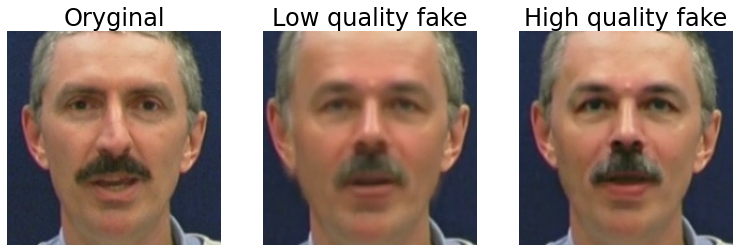

In [35]:
pat = os.getcwd();
plt.rcParams['figure.figsize'] = [13, 6];
plt.rcParams.update({'font.size': 20});

plt.subplot(131);
image_0 = cv2.imread(os.path.join(pat, '1d', 'f60.jpg'));
plt.axis('off');
plt.imshow(cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB));
plt.title('Oryginal');
plt.subplot(132);
image_1 = cv2.imread(os.path.join(pat, '2d', 'f60.jpg'));
plt.axis('off');
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB));
plt.title('Low quality fake');
plt.subplot(133);
image_2 = cv2.imread(os.path.join(pat, '3d', 'f60.jpg'));
plt.axis('off');
plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB));
plt.title('High quality fake');

Features will be stored in dictionary.

In [36]:
features = {}

Now the key differences between histograms can be computed.

In [37]:
index = {}		# initialize the index dictionary to store the image name
images = {}		# and corresponding histograms and the images dictionary
images_gray = {}		# to store the images themselves
f = 1
pat = os.getcwd()    # getting the full path to actual folder


def getting_data(pat):
	for imagePath in glob.iglob(pat+'/*',
						recursive = True): 		# 1 (from Workflow list)
		if "d" in imagePath and '.jpg' in imagePath and 'f60' in imagePath:			
			global f
			filename = imagePath[imagePath.rfind("/") + 1:]
			image = cv2.imread(imagePath)		# load the image, updating the images dictionary
			filename = filename.replace('0.', str(f) + '.')
			h, w = image.shape[0:2]
			images[filename] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
			images_gray[filename] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
			hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],
						[0, 256, 0, 256, 0, 256])
			hist = cv2.normalize(hist, hist).flatten()
			index[filename] = hist
			image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)		# because cv2 uses BGR and matplotlib RGB					plt.figure(f)
			plt.figure(f)
			plt.imshow(image)
			plt.axis("off")
			plt.figure(f+3)		# plotting gray scale histogram
			gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
			plt.hist(gray.ravel(),256,[0,256]);
			plt.xlabel('Intensity Value')
			plt.ylabel('Count')
			plt.title('Gray scale histogram (no. {})'.format(f))
			plt.figure(f+6)		# plotting the color histogram
			plt.hist(image.ravel(), bins = 256, color = 'orange', )
			plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'Red', alpha = 0.3)
			plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.3)
			plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.3)
			plt.xlabel('Intensity Value')
			plt.ylabel('Count')
			plt.title('Color image histogram (no. {})'.format(f))
			plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
			f += 1								# updating global variable
			getting_data(imagePath)			# recursion
		else:
			getting_data(imagePath)			# recursion if folder is not the desired one

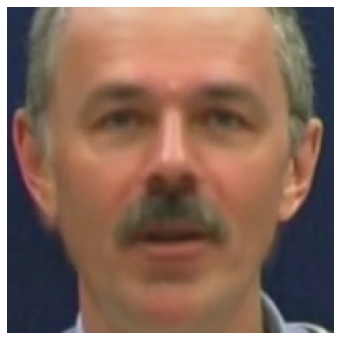

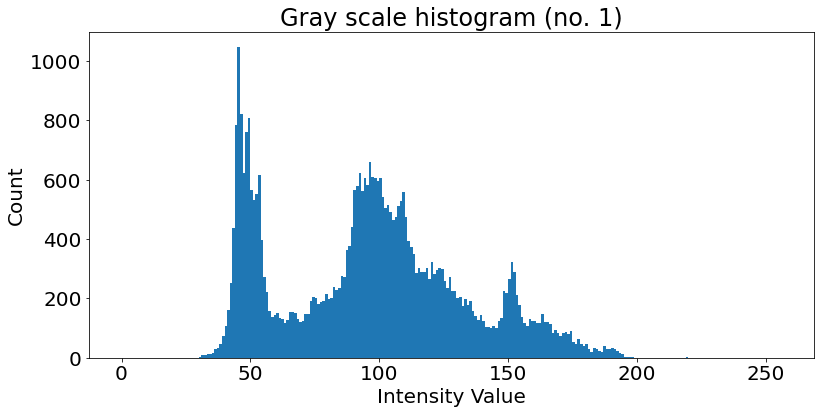

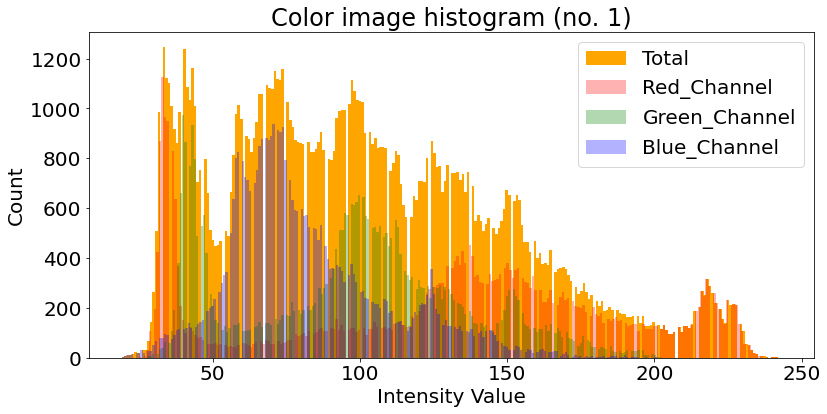

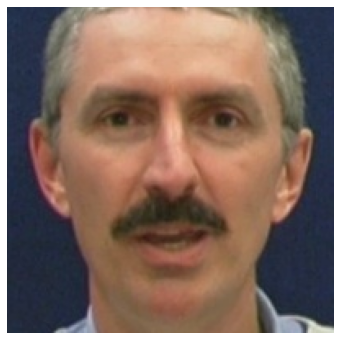

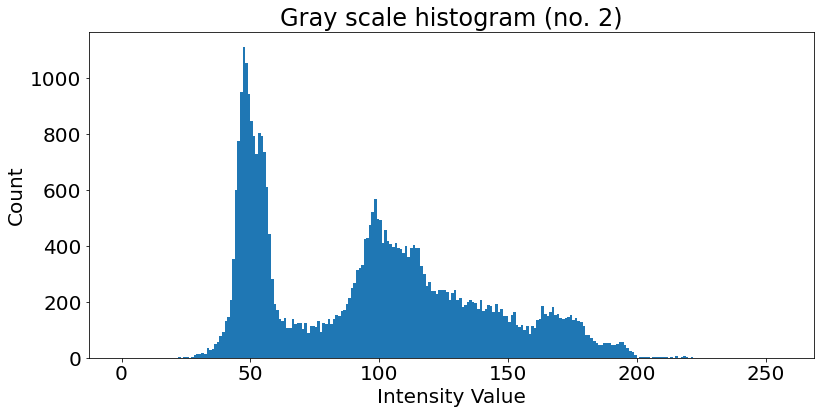

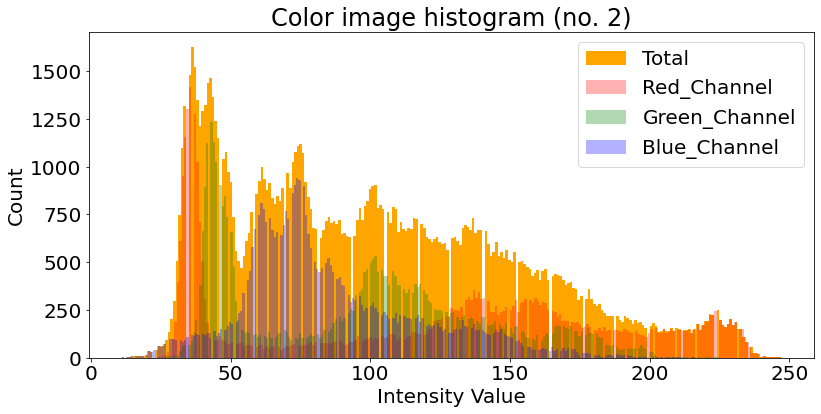

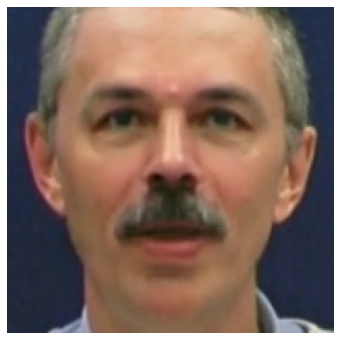

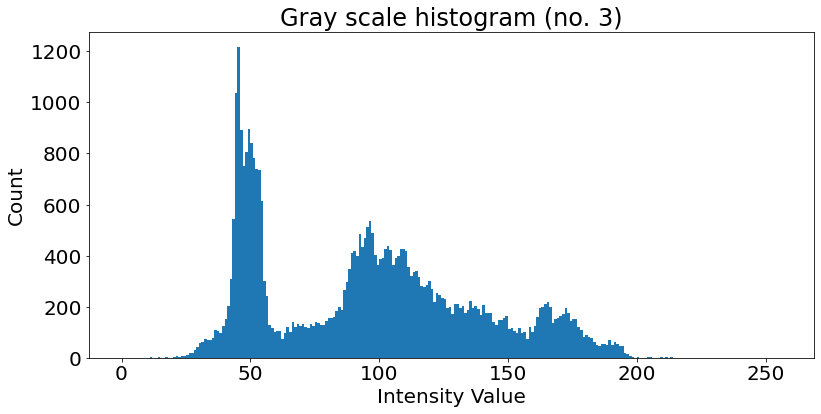

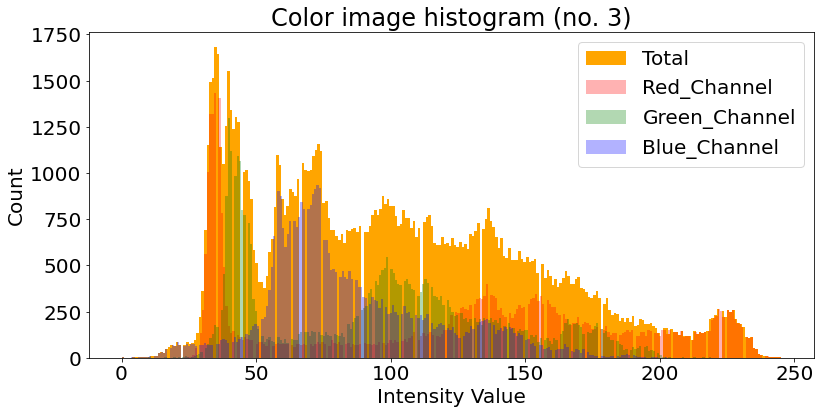

In [38]:
getting_data(pat)

/home/ricz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


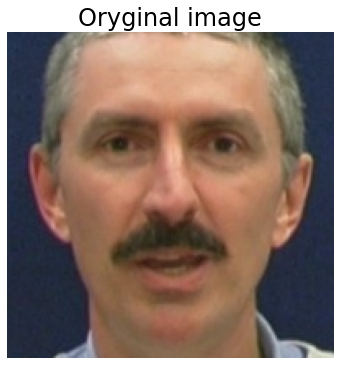

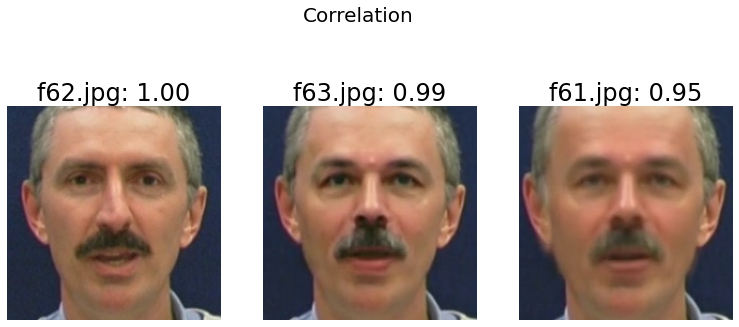

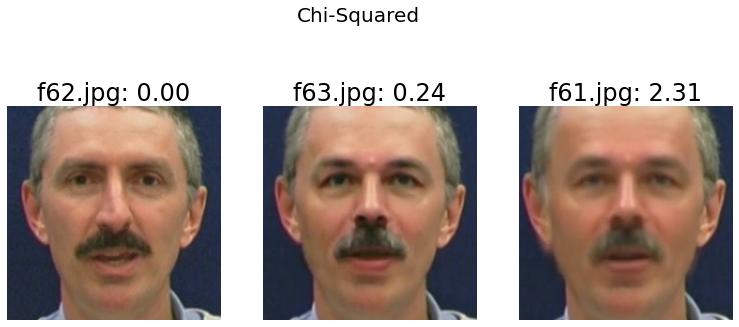

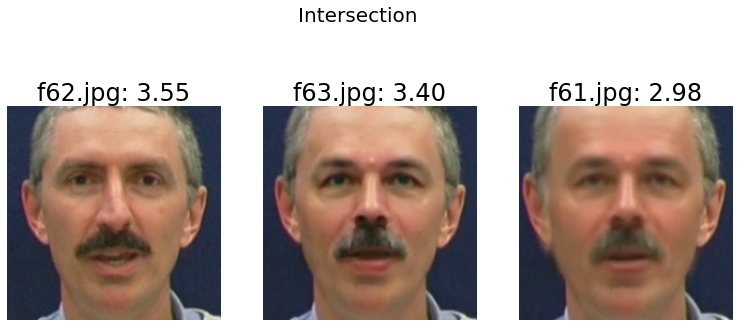

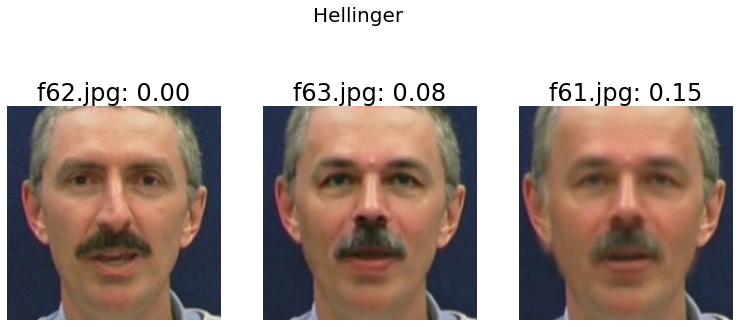

In [39]:
OPENCV_METHODS = (  	# initialize OpenCV methods for histogram comparison
	("Correlation", cv2.HISTCMP_CORREL),
	("Chi-Squared", cv2.HISTCMP_CHISQR),
	("Intersection", cv2.HISTCMP_INTERSECT),
	("Hellinger", cv2.HISTCMP_BHATTACHARYYA))
for (methodName, method) in OPENCV_METHODS: 	# loop over the comparison methods
	results = {}
	reverse = False
	# if we are using the correlation or intersection
	# method, then sort the results in reverse order
	if methodName in ("Correlation", "Intersection"):
		reverse = True

	# loop over the index
	for (k, hist) in index.items():		# compute the distance between the two histograms
		d = cv2.compareHist(index['f62.jpg'], hist, method)
		results[k] = d
	results = sorted([(v, k) for (k, v) in results.items()], reverse = reverse)
	fig = plt.figure("Query")		# show the query image
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(images["f62.jpg"])
	ax.set_title("Oryginal image")
	plt.axis("off")

	# initialize the results figure
	fig = plt.figure("Results: %s" % (methodName))
	fig.suptitle(methodName, fontsize = 20)
	# loop over the results
	for (i, (v, k)) in enumerate(results):
		# show the result
		ax = fig.add_subplot(1, len(images), i + 1)
		ax.set_title("%s: %.2f" % (k, v))
		plt.imshow(images[k])
		plt.axis("off")
plt.show()

Next script should calculate numerical dependencies. **MSE** will calculate the **mean square error between each pixels** for the two images. **SSIM** will do the opposite and **look for similarities within pixels**; i.e. if the pixels in the two images line up and or have similar pixel density values.

In [45]:
def mse(image_1, image_2):
    err = np.sum((image_1.astype("float") - image_2.astype("float"))**2)
    err /= float(image_1.shape[0]*image_2.shape[1])
    return err

**PSNR** (peak signal-to-noise ratio) is the ratio between the maximum possible power of an image and the power of corrupting noise that affects the quality of its representation.

In [48]:
def psnr(image_1, image_2, mse): 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse)) 
    return psnr 

SSIM: 0.6033027252842724
MSE: 606.900225
PSNR: 20.29963062368644
SSIM: 0.7055835382537392
MSE: 302.85705
PSNR: 23.31842673109763


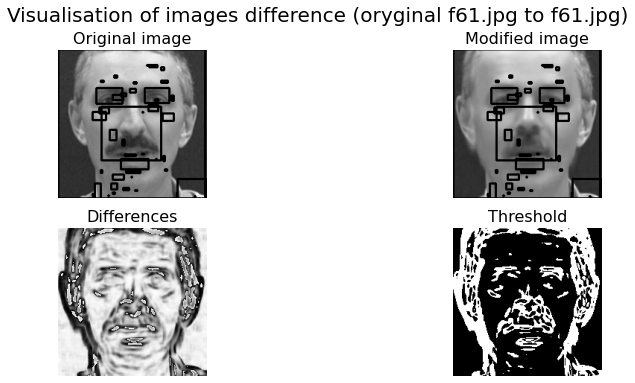

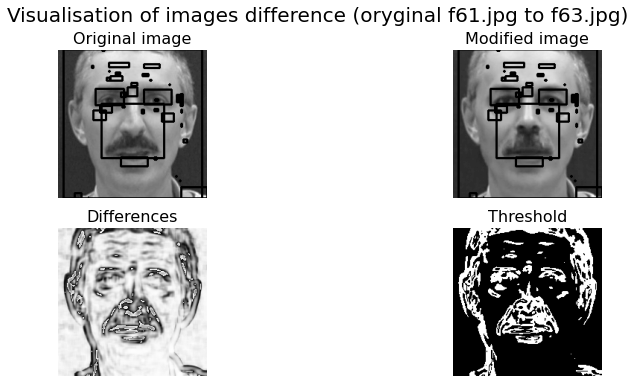

In [49]:
######################################################################################
# saving the differences on images as a image
######################################################################################

origin = images_gray["f62.jpg"].copy()

for (k, image) in images_gray.items():
	images_gray["f62.jpg"] = origin.copy()
	im = image
	if k != "f62.jpg":
		(score, diff) = ssim(origin, im, full = True)
		diff = (diff * 255).astype("uint8")
		print("SSIM: {}".format(score))
		err = mse(origin, im)
		print("MSE: {}".format(err))
		print("PSNR: {}".format(psnr(origin, im, err)))
		# threshold the difference image, followed by finding contours to
		# obtain the regions of the two input images that differ
		thresh = cv2.threshold(diff, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		# loop over the contours
		for c in cnts:
			# compute the bounding box of the contour and then draw the
			# bounding box on both input images to represent where the two
			# images differ
			(x, y, w, h) = cv2.boundingRect(c)
			cv2.rectangle(images_gray["f62.jpg"], (x, y), (x + w, y + h), (0, 0, 255), 2)
			cv2.rectangle(im, (x, y), (x + w, y + h), (0, 0, 255), 2)
		# show the output images
		fig_2 = plt.figure("Query {}".format(k))	# show the query image
		fig_2.suptitle("Visualisation of images difference (oryginal f61.jpg to {})".format(k), fontsize = 20)
		plt.subplot(221)
		plt.imshow(images_gray["f62.jpg"], cmap='gray')
		plt.axis("off")
		plt.title("Original image", fontsize = 16)
		plt.subplot(222)
		plt.imshow(im, cmap='gray')
		plt.axis("off")
		plt.title("Modified image", fontsize = 16)
		plt.subplot(223)
		plt.imshow(diff, cmap='gray')
		plt.axis("off")
		plt.title("Differences", fontsize = 16)
		plt.subplot(224)
		plt.imshow(thresh, cmap='gray')
		plt.axis("off")
		plt.title("Threshold", fontsize = 16)
	else:
		pass

plt.show()

Clearly performance of correlation, intersection and Hellinger parameters is much betters performed on cropped faces. Returned differences are (as before) mostly visible in Chi-Squared and Hellinger distances. SSIM (Structural Similarity Index) values are nearly the same but both fairly far from 1.

Now the differences between each fake and oryginal and histograms of two difference images can be display explicitly.

In [51]:
def display_histogram(real_image, fake_image):
    fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3)
    ax_1.set_title('Oryginal')
    ax_1.hist(real_image.ravel(), 256, [0,256])
    ax_2.set_title('Deepfake')
    ax_2.hist(fake_image.ravel(), 256, [0,256])
    ax_3.set_title('Difference')
    ax_3.hist(image_diff.ravel(), 256, [0,256])
    fig.tight_layout(pad = .5)

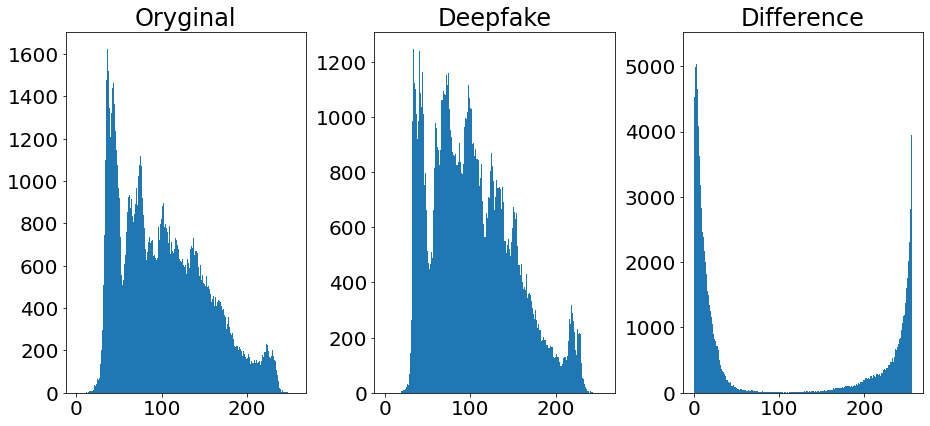

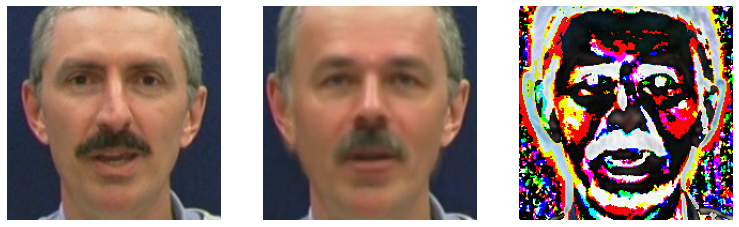

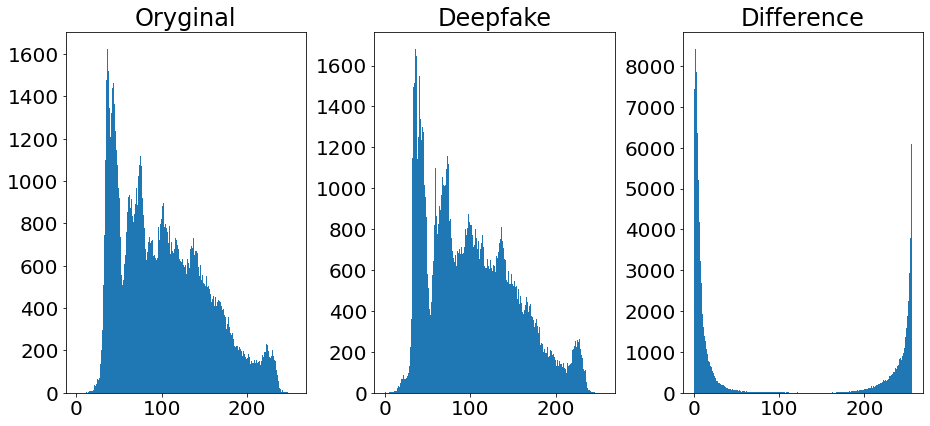

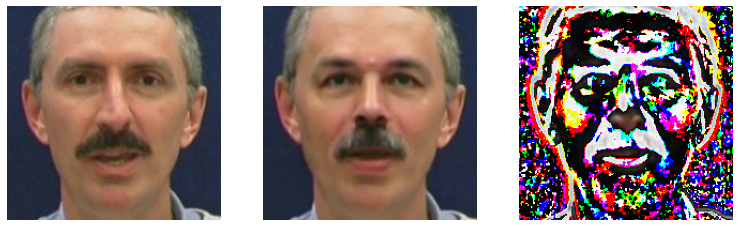

In [53]:
origin = images["f62.jpg"].copy()

for (k, image) in images.items():
    images["f62.jpg"] = origin.copy()
    im = image
    if k != "f62.jpg":
        image_diff = origin - im
        display_histogram(origin, im)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(origin)
        ax1.axis('off')
        ax2.imshow(im)
        ax2.axis('off')
        ax3.imshow(image_diff)
        ax3.axis('off')
    else:
        pass

It is worth mentioning that difference between identical images will be zero.

## Feature Matching

First running the script that simply represents similar patterns on both images.

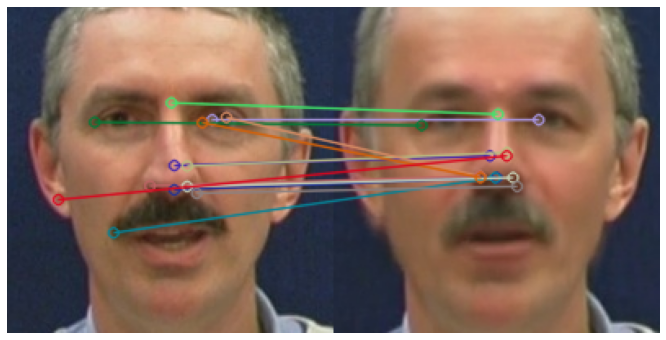

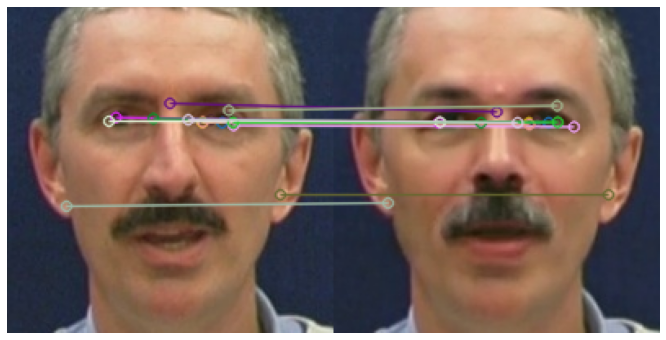

In [16]:
for (k, image) in images.items():
	images["f62.jpg"] = origin.copy()
	im = image
	if k != "f62.jpg":
		orb = cv2.ORB_create()		# Initiate ORB detector
		kp1, des1 = orb.detectAndCompute(origin,None)		# keypoints and descriptors with ORB
		kp2, des2 = orb.detectAndCompute(im,None)
		bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)	# create BFMatcher object
		matches = bf.match(des1,des2)		# match descriptors
		matches = sorted(matches, key = lambda x:x.distance)		# sort them in the order of their distance
		img3 = cv2.drawMatches(origin, kp1, im, kp2, matches[:15],None,    # draw matches
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
		plt.axis('off')
		plt.imshow(img3),plt.show()
	else:
		pass

It is obvious that elements of nose and eyes are **strongly** correlated. One missmatch is between nose and lisps element (green line on second images row). Next script will also return only the best matches between two images.

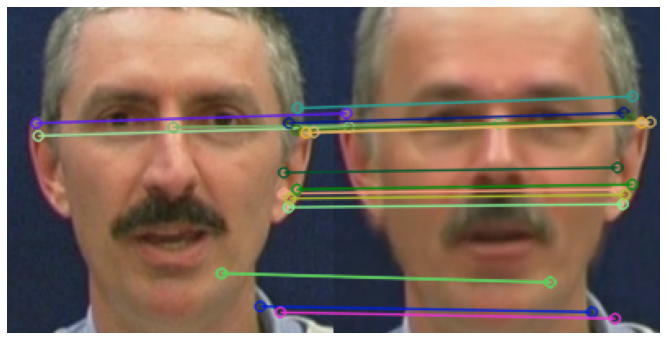

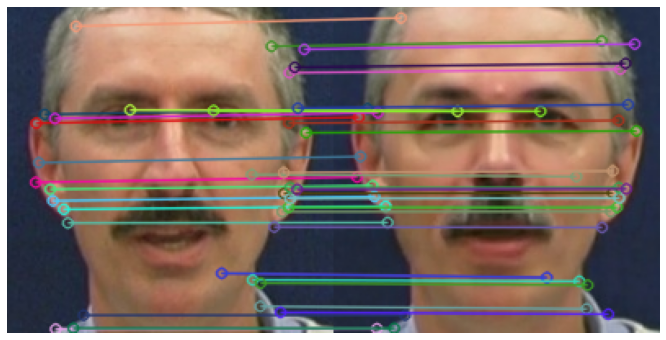

In [17]:
for (k, image) in images.items():
    images["f62.jpg"] = origin.copy()
    im = image
    if k != "f62.jpg":
        # Initiate SIFT detector
        sift = cv2.xfeatures2d.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(origin, None)
        kp2, des2 = sift.detectAndCompute(im, None)
        bf = cv2.BFMatcher.create()
        matches = bf.knnMatch(des1,des2,k = 2)    # k - no. of matches
        good = []
        for m,n in matches:    # Apply ratio test
            if m.distance < 0.475*n.distance:
                good.append([m])
        img3 = cv2.drawMatchesKnn(origin, kp1, im, kp2, good, None,
                                 flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3) 
        plt.axis('off')
        plt.show()
    else:
        pass

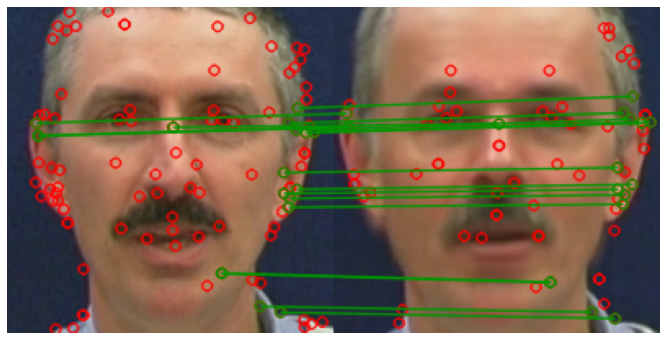

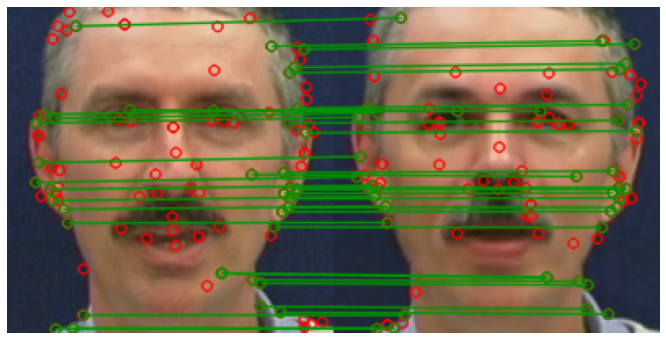

In [18]:
for (k, image) in images.items():
    images["f62.jpg"] = origin.copy()
    im = image
    if k != "f62.jpg":
        sift = cv2.xfeatures2d.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(origin, None)
        kp2, des2 = sift.detectAndCompute(im, None)
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1,des2,k=2)
        # create a mask
        matchesMask = [[0,0] for i in range(len(matches))]
        # ratio test
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.475*n.distance:
                matchesMask[i]=[1,0]
        draw_params = dict(matchColor = (0,150,0),
                           singlePointColor = (255,0,0),
                           matchesMask = matchesMask,
                           flags = cv2.DrawMatchesFlags_DEFAULT)
        img3 = cv2.drawMatchesKnn(origin, kp1, im, kp2, matches, None, **draw_params)
        plt.imshow(img3)
        plt.axis('off')
        plt.show()
    else:
        pass

On two last images it is clearly visible how many common elements better quality fake shares with the oryginal. Last step of evaluation will be template matching process.

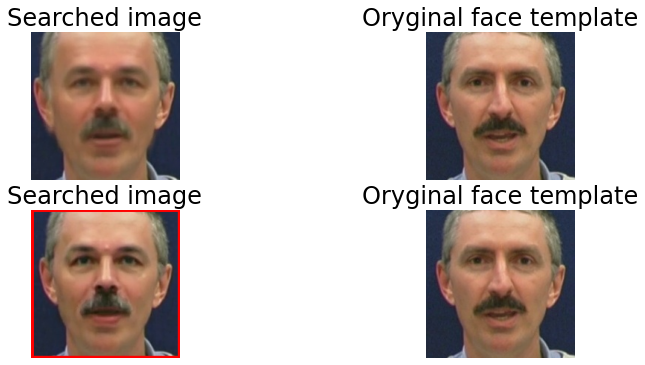

In [74]:
img = []
temp = []
for (k, image) in images.items():
    im = image.copy()
    if k != "f62.jpg":  
        img_rgb = im.copy()
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY) 
        template = origin
        h, w = template.shape[0:2]   # hight and width

        res = cv2.matchTemplate(img_gray, cv2.cvtColor(template, cv2.COLOR_BGR2GRAY),
                                cv2.TM_CCOEFF_NORMED)   # match operation
        threshold = 0.921

        loc = np.where( res >= threshold)    # coordinates of matched area
        for pt in zip(*loc[::-1]):
            if pt != []:
                rec = cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255,0,0), 6) 

        img.append(img_rgb)
        temp.append(template)
    else:
        pass

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2);
ax1.imshow(img[0]);
ax1.set_title("Searched image");
ax1.axis('off');
ax2.imshow(temp[0]);
ax2.set_title("Oryginal face template");
ax2.axis('off');
ax3.imshow(img[1]);
ax3.set_title("Searched image");
ax3.axis('off');
ax4.imshow(temp[1]);
ax4.axis('off');
ax4.set_title("Oryginal face template");



From above script it is obvious that every threshold above 0.921 will reject better quality fake. After trying to simply find the oryginal face template on deep fake frame multiscaling method can be implemented.

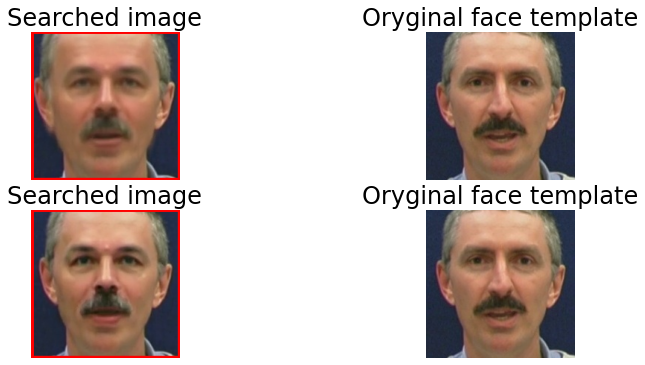

In [54]:
img = []
contour = []
for (k, image) in images.items():
    im = image.copy()
    if k != "f62.jpg":
        img_rgb_1 = im.copy()
        img_gray = cv2.cvtColor(img_rgb_1, cv2.COLOR_BGR2GRAY) 
        # Read the template 
        template = origin
        # Store width and height of template in w and h 
        h, w = template.shape[0:2] 
        found = None

        for scale in np.linspace(0.2, 1.0, 20)[::-1]: 
            # resize the image according to the scale, and keep track 
            # of the ratio of the resizing 
            resized = imutils.resize(img_gray, width = int(img_gray.shape[1] * scale)) 
            r = img_gray.shape[1] / float(resized.shape[1]) 

            # if the resized image is smaller than the template, then break 
            # from the loop 
            # detect edges in the resized, grayscale image and apply template 
            # matching to find the template in the image 

            # compute the median of the single channel pixel intensities
            v = np.median(image)
            # apply automatic Canny edge detection using the computed median
            sigma = 0.33
            lower = int(max(0, (1.0 - sigma)*v))
            upper = int(min(255, (1.0 + sigma)*v))
            edged = cv2.Canny(resized, lower, upper) 
            result = cv2.matchTemplate(edged, 
                        cv2.cvtColor(template, cv2.COLOR_BGR2GRAY), cv2.TM_CCOEFF) 
            (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result) 
            # if we have found a new maximum correlation value, then update 
            # the found variable 
            if found is None or maxVal > found[0]: 
                if resized.shape[0] < h or resized.shape[1] < w: 
                        break
            found = (maxVal, maxLoc, r) 

        # unpack the found varaible and compute the (x, y) coordinates 
        # of the bounding box based on the resized ratio 
        (_, maxLoc, r) = found 
        (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r)) 
        (endX, endY) = (int((maxLoc[0] + w) * r), int((maxLoc[1] + h) * r)) 
        # draw a bounding box around the detected result and display the image 
        cv2.rectangle(img_rgb_1, (startX, startY), (endX, endY), (255, 0, 0), 6) 
        img.append(img_rgb_1)
    else:
        pass

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2);
ax1.imshow(img[0]);
ax1.set_title("Searched image");
ax1.axis('off');
ax2.imshow(origin);
ax2.set_title("Oryginal face template");
ax2.axis('off');
ax3.imshow(img[1]);
ax3.set_title("Searched image");
ax3.axis('off');
ax4.imshow(origin);
ax4.axis('off');
ax4.set_title("Oryginal face template");

## Define features

**Objective**

From the above methods that compare images, select those that you can use as features. One feature should not be too large and should be representative enough for later classification. Also, the features are extracted from each frame (or a face) independently, which means there is no reference image to compare to. The trick, therefore, is to synthesize that reference. One way to do it is to create a blurred version of the same image and compute features between our image and its blurred version. Store computed features in HDF5 format.

**Workflow**

The task of defining good features is the most crucial one. The features you select will have a direct impact on the accuracy of the Deepfake detection. Some point to consider
* You need to use features that would look different for original faces and Deepfake faces.You can take features from the matching and image similarity methods you have explored. Histograms could be helpful too.
* The most important point to understand here is that during feature computation, the system can only see one video at a time. It means the features should be computed for each face independently, i.e., given one image, and you should be able to produce a set of values that describes that image well. If a particular method of image similarity that you would like to use for feature computation requires two input images (usually reference and probe), then you can use a trick to make this method still work even though you have only one image (and no reference). You can create a second image artificially by **blurring** your probe image with Gausssian blur. Then, compute the similarity by using your image and its blurred version. Besides **Structural Similarity Index (SSIM)** computed using the image and its blurred version, you can also consider the following features (also computed using the image and its blurred version): 
    1. mean squared error (**MSE**), 
    2. peak signal-to-noise ratio (**PSNR**), 
    3. **average difference between the image and its blurred version**. 


* You can also add a histogram of the image or the histogram of the difference between the image and its blurred version. In the end, there should not be more than 300 values in the feature vector that you would compute for one image (face). Typically, you can **aim to have from 40 to 150 feature values per image**.
* Extract features for a frame (face) and store them in HDF5 format, which is a good way to store numpy arrays. For a given facial image, compute features and then save the features in HDF5 file. You do not need to save the image as HDF5 files; just features is good enough. The resulting HDF5 file should contain one feature vector for this image.

In [55]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [56]:
chi2_selector = SelectKBest(chi2, k=2)